<a href="https://colab.research.google.com/github/jf-v/ML-Price_prediction_SMA/blob/main/ML_Price_movement_prediction_using_SMA_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for price movement prediction using SMA indicators 


###**Objetive**
* Create and train a machine learning model, then use it
to get price movement predictions for a certain amount of bars towards future. 
The predictions will estimate the probabilities of the price to be above or below the current price after a certain amount of time, defined by the shift bars and timeframe of the price data. Example: a prediction target shift of 7 bars on a 1 hour timeframe will be the price expected position (up or down) after 7 hours

####**Resources**
* Data for model training from [CryptoDataDownload](https://www.cryptodatadownload.com/): provides a larger amount of historical bars to train the model, even there are only two timeframes available, 1 hour or 1 day.
* Data for predictions obtained with [cryptowatch-sdk](https://github.com/cryptowatch/cw-sdk-python): limited to 1000 historical bars, but it provides more timeframes for backtesting
* Model save and load with pickle library


###**Fast Execution**

*  **Run** all cells except 6 and 7, or Create Model and Predictions block as whole, using default inputs


####**Create model**

*   **Create** and **train** a new model by executing cells from 1 to 5. Can save the model to local computer or google drive on cell 6


####**Load model (instead of creating it again)**

*   **Load a pretrained model** on cell 7. Execute first cells 1,2 and 4. Input the SMA values used on the pretrained model


####**Predictions**

*   Execute **Prediction Init**(cell 8). Can be used recent price data from  different exchanges or input a custom historic bar data

*   With the model already created or loaded and the prediction init cell executed, **run the model prediction**(cell 9) any times as needed. It can predict for bar series starting from current or for a historic bar selected by shift toward current bar index(0)
*   Enable **predictions results** and **trades table** to see profits and losses in detail for each filtered prediction


** **DISCLAIMER**: The resources available on this project are purely and exclusively for educational purposes, and are not intended as, and shall not be understood or construed as, financial advice.*





# Create model

In [10]:
#@title # 1.  **Download price data** and convert it into a DataFrame
#@markdown * Data from cryptodatadownload.com
#@markdown * Check available symbols and timeframes on https://www.cryptodatadownload.com/data/bitstamp/   links to each csv
#@markdown * Symbol: BTCUSDT, ETHUSDT and more available
Symbol = "BTCUSDT" #@param {type:"string"}
Timeframe = "1h" #@param ["1h", "d"]

#   Import libraries

import pandas as pd
pd.set_option("display.precision", 2)
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display

import pickle
import os 
from google.colab import drive

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


# Download price data of binance
data_url='https://www.cryptodatadownload.com/cdd/Bitstamp_'+Symbol+'_'+Timeframe+'.csv' 
data_path='data.csv'
!wget -O $data_path $data_url


# Load the historical price data to a dataframe

df = pd.read_csv(data_path, skiprows=1)
df.head()
print('Price data shape: '+str(df.shape))

--2023-01-10 22:21:56--  https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSDT_1h.csv
Resolving www.cryptodatadownload.com (www.cryptodatadownload.com)... 35.173.69.207
Connecting to www.cryptodatadownload.com (www.cryptodatadownload.com)|35.173.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643237 (628K) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>] 628.16K   855KB/s    in 0.7s    

2023-01-10 22:21:58 (855 KB/s) - ‘data.csv’ saved [643237/643237]

Price data shape: (6796, 9)


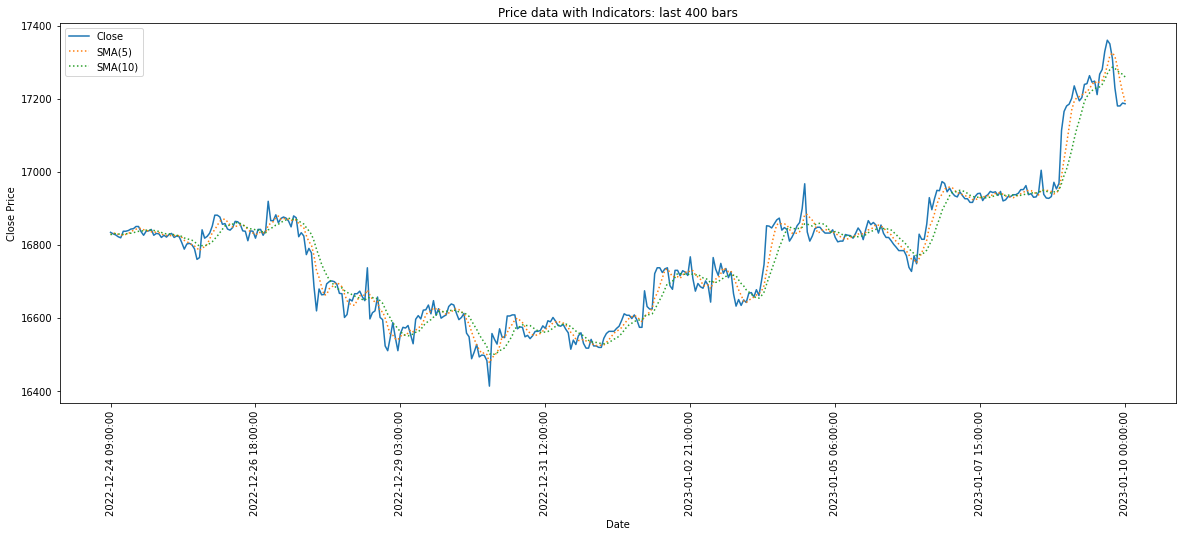

In [2]:
#@title # 2.  Calculate **SMA indicators**
sma_1 = 5 #@param {type:"integer"}
sma_2 = 10 #@param {type:"integer"}
show_previous_bars = 400 #@param {type:"integer"}

#   Calculate the indicators based on the 'close' values
df['indicator_1'] = df['close'][::-1].rolling(sma_1).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again
df['indicator_2'] = df['close'][::-1].rolling(sma_2).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again


#   Plot the indicator values for the last bars

bars = show_previous_bars

#  Set plot figure size
plt.rcParams["figure.figsize"] = (20,7)

# Define plot x,y
x = df['date'][:bars]
y = df['close'][:bars]
plt.plot(x,y,label='Close')

# Calculate indicators
plt.plot(df['indicator_1'][:bars],label='SMA('+str(sma_1)+')',linestyle='dotted')
plt.plot(df['indicator_2'][:bars],label='SMA('+str(sma_2)+')',linestyle='dotted')
plt.legend()

# Set title and labels
plt.title('Price data with Indicators: last '+str(show_previous_bars)+' bars')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Fix dates ticks
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) //7])  # set new tick positions
ax.tick_params(axis='x', rotation=90)     # set tick rotation

# Invert x orientation
plt.gca().invert_xaxis()

# Set graph size and show it
plt.show()


In [3]:
#@title # 3.  Prepare a **new column with future prices** by a shift bar. Later, use this as a **target** to train the model for price movement prediction
#@markdown * Price shift will determine the time target for the prediction, and is based on the price data timeframe. If is H1, then the shift will be the amount of hours toward future for the prediction
future_price_shift = 7 #@param {type:"integer"}

# Shift the close price column by 5 slots to create the target column
df["price_change"] = df["close"].shift(-(future_price_shift))

# Calculate the change in price between the current and the next slots
df["price_change"] = df["price_change"] - df["close"]

# Create a target column that indicates whether the price will go up (1) or down (-1)
df["target"] = np.where(df["price_change"] > 0, 1, -1)

# Drop rows with missing values (there will be some at the end of the dataframe)
df.dropna(inplace=True)

# Define the labels
y = df["target"]

In [3]:
#@title # 4.  Define **model inputs**

#   Preprocess the data to prepare it for training the model

# Select the relevant features to use as input for the model
X = df[["close", "indicator_1", "indicator_2"]]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#@title # 5. **Init** RandomForestClassifier model. Then **train** it and apply **hyperparameter tuning** using grid search

# Define the model
model = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [5, 10, 20, None],
}

# Use grid search to find the best combination of hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_scaled, y)

# Print the best combination of hyperparameters
print('Best combination of hyperparameters:')
print(grid_search.best_params_)

# Use the best combination of hyperparameters to train the model
model = RandomForestClassifier(**grid_search.best_params_)
model.fit(X_scaled, y)

# Evaluate the model using cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)

# Print the mean and standard deviation of the scores
print(f"Mean score: {np.mean(scores):.2f}")
print(f"Standard deviation: {np.std(scores):.2f}")

Best combination of hyperparameters:
{'max_depth': None, 'n_estimators': 200}
Mean score: 0.67
Standard deviation: 0.13


In [ ]:
#@title # 6.  **Save** trained model with pickle library
Download = False #@param {type:"boolean"}
Save_to_drive = True #@param {type:"boolean"}
model_name = "ML-Binance_BTCUSDT_H1-sma5_10-target_shift_7" #@param {type:"string"}

content_folder=''


#   Prepare drive

if Save_to_drive:
  drive.mount('/content/gdrive')      # mount drive
  
  content_folder = "/content/gdrive/MyDrive"  
  os.chdir(content_folder)    
  
  folder = "ML-Price_prediction_SMA"
  if os.path.isdir(folder)==False:
    os.mkdir(folder)    
  content_folder += "/"+folder+'/'
  

#   Save model to pickle file

file_path = content_folder+model_name+'.pkl'
with open(file_path, 'wb') as model_file:
  pickle.dump(model, model_file)
  if Save_to_drive: print("Saved on folder: "+content_folder)


#   Download to local computer

if Download:       
  from google.colab import files       
  files.download(file_path)  

______________________________________________________________________________________________________________________________________________

# Load model

In [4]:
#@title # 7.  **Load** pretrained model with pickle library
#@markdown # Execute cells 1, 2, 4  before to run this one
#@markdown To load a saved model from a Pickle file, all you need to do is pass the “pickled” model into the Pickle load() function and it will be deserialized. By assigning this back to a model object, you can then run your original model’s predict() function, pass in some test data and get back an array of predictions.
model_name = "ML-Binance_BTCUSDT_H1-sma5_10-target_shift_7" #@param {type:"string"}
Load_from_drive = True #@param {type:"boolean"}
#@markdown * Input the SMA periods used on the loaded model
sma_1 = 5 #@param {type:"integer"}
sma_2 = 10 #@param {type:"integer"}


model_loaded=True
content_folder=''

#   Prepare drive

if Load_from_drive:
  drive.mount('/content/gdrive')      # mount drive
  content_folder = "/content/gdrive/MyDrive"  
  os.chdir(content_folder)    
  
  folder = "ML-Price_prediction_SMA"
  if os.path.isdir(folder)==False:
    print("Error: default models folder doesn't exist on drive")
  content_folder += "/"+folder+'/'


#   Load model from pickle file

model = pickle.load(open(content_folder+model_name+'.pkl', 'rb'))
if model != None: print('Success to load model: '+model_name)
# model.predict(X_test)     use it like this



Mounted at /content/gdrive
Success to load model: ML-Binance_BTCUSDT_H1-sma5_10-target_shift_7


__________________________________________________________________________________________________________________________

# Predictions

In [5]:
#@title # 8.  Prediction **init**
Use_cryptowatch_prices = True #@param {type:"boolean"}

#   Check the model
try:
  model
except NameError as e:
  print('There is not available model yet. Load or create a new one first\n')

#   Use recent price data from binance exchange, to make predictions

if Use_cryptowatch_prices:
  print('Installing cryptowatch-sdk to get prices data')
  !pip install cryptowatch-sdk
  import cryptowatch as cw


#   Predictions function, it will return a string with the result

def predict(close,indicator_1,indicator_2,probability_threshold):
  # Select the features for the new data
  inputs = {'close':[close], 
            'indicator_1':[indicator_1], 
            'indicator_2':[indicator_2]}
  X_new = pd.DataFrame(inputs)

  # Normalize the data
  #X_new_scaled = scaler.fit_transform(X_new)
  X_new_scaled = scaler.transform(X_new)

  # Make a prediction using the model
  prediction = model.predict(X_new_scaled)

  # Make a probabilities prediction using the model
  probabilities = model.predict_proba(X_new_scaled)
  probability = str(probabilities[[0]]).split()

  # Return the prediction: Outputs either 1(buy) or -1(sell)
  result = ""
  p = 0
  if prediction[0] == 1:  
    p = float(probability[1].replace("]","")[0:4])*100
    result+=("B U Y    ("+str(p)+" % probability)")
  else:                   
    p = float(probability[0].replace("[","")[0:4])*100
    result+=("S E L L  ("+str(p)+" % probability)")
  if p >= probability_threshold:
    result += "  ✓"
  return result

Installing cryptowatch-sdk to get prices data
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 6.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: marshmallow
    Found existing installation: marshmallow 3.19.0
    Uninstalling marshmallow-3.19.0:
      Successfully uninstalled marshmallow-3.19.0


* Prediction target shift was determined during model training

Historic bar Series prediction, ending on current bar at 2023-01-10 23:00:00



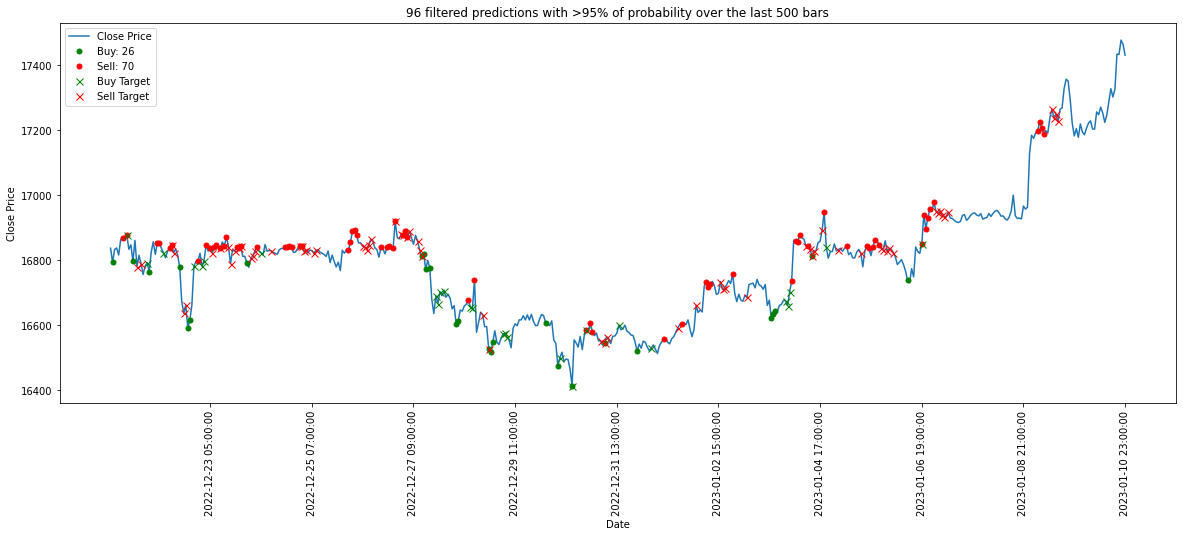

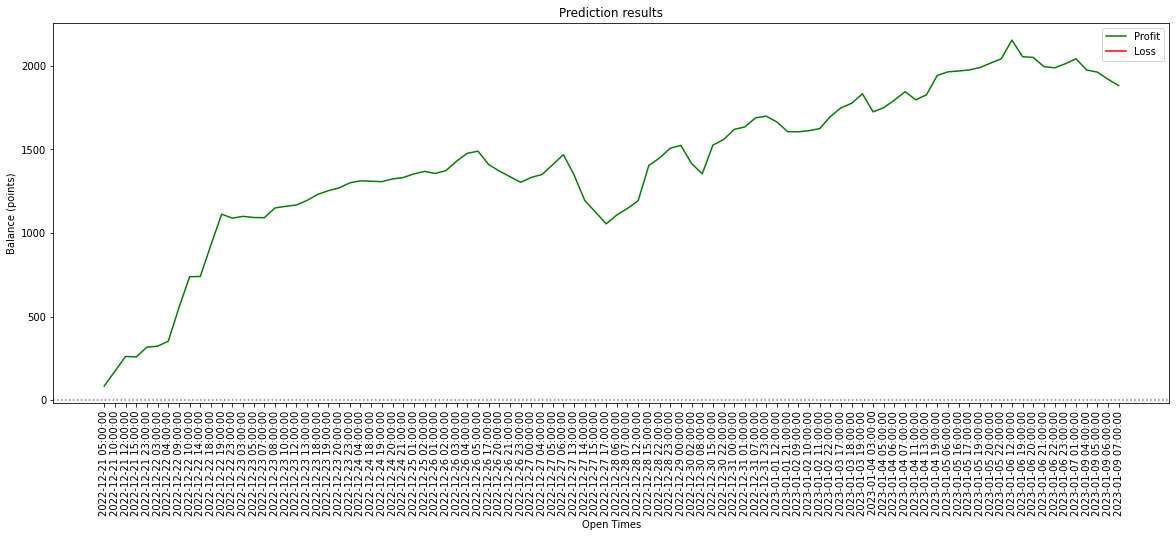

,Total profits,Profit Avg,Max Drawdown,Win Avg,Loss Avg,Win Rate,Profit Factor
Points,1882.00,21.74,-153.34,49.71,-46.64,72.92,1.04
Price %,11.18,0.13,-0.91,0.30,-0.28,,


,Open,Close,Profit,Type,Open time,Balance
95,17189.24,17226.90,-37.66,Sell,2023-01-09 07:00:00,1882.00
94,17205.95,17249.06,-43.11,Sell,2023-01-09 06:00:00,1919.66
93,17226.49,17238.93,-12.44,Sell,2023-01-09 05:00:00,1962.77
92,17197.00,17264.50,-67.50,Sell,2023-01-09 04:00:00,1975.21
91,16978.18,16948.09,30.09,Sell,2023-01-07 01:00:00,2042.71
90,16958.35,16934.28,24.07,Sell,2023-01-06 23:00:00,2012.62
89,16931.27,16938.27,-7.00,Sell,2023-01-06 22:00:00,1988.55
88,16897.48,16952.46,-54.98,Sell,2023-01-06 21:00:00,1995.55
87,16939.91,16944.24,-4.33,Sell,2023-01-06 20:00:00,2050.53
86,16850.45,16950.02,-99.57,Sell,2023-01-06 19:00:00,2054.86


In [12]:
#@title # 9.  Make price movement **predictions**
#@markdown __________________________________________________________________________________
#@markdown # Use recent prices from cryptowatch
#@markdown * Make sure that **Use_cryptowatch_prices** was **enabled** on the prediction init cell
#@markdown * Enable **refresh data** only once at every new bar or when changing symbol or exchange, to avoid reaching the free requests limit
refresh_data = True #@param {type:"boolean"}
#@markdown * Enter the same symbol and timeframe than the one used for training the model. It might work with other timeframes also
symbol = "BTCUSDT" #@param {type:"string"}
timeframe = "1h" #@param ["1h","1d","1m","3m","5m","15m","30m","2h","4h","6h","12h","3d","1w","1w_monday"] 
#@markdown * Select exchange
exchange = "Binance" #@param ["Binance", "Huobi", "Kraken", "Coinbase Pro", "Crypto.com", "Bitfinex", "Bitstamp"]
#@markdown * Prediction mode **Single Bar**: enter the bar shift that will be used for prediction starting from current bar as 0. No further than (1000-largest SMA period)
#@markdown * Prediction mode **Bar Series**: enter the amount of bars to get prediction, starting from the current bar. No further than (1000-largest SMA period)
Prediction_mode = "Bar Series" #@param ["Single Bar", "Bar Series"]
Prediction_shift_or_range = 500 #@param {type:"slider", min:0, max:980, step:1}
#@markdown #### Prediction **probability threshold** filter (recommended >94%)
probability_threshold = 95 #@param {type:"slider", min:1, max:100, step:1}
#@markdown #### Show predictions **probability** (convert to interactive table with right upper button)
show_probability_table = False #@param {type:"boolean"}
#@markdown #### Plot predictions **targets**, show **results** and **trades list**
Target_bar_shift = 7 #@param {type:"number"}
plot_targets = True #@param {type:"boolean"}
show_prediction_results = True #@param {type:"boolean"}
show_prediction_table = True #@param {type:"boolean"}

#@markdown __________________________________________________________________________________
#@markdown # Use custom prices
#@markdown * Make sure that **Use_cryptowatch_prices** was **disabled** on the prediction init cell
#@markdown * Last bar or older. Don't use current bar values until is already closed
Close = 16608.63 #@param {type:"number"}
SMA_1 = 16596.32 #@param {type:"number"}
SMA_2 = 16739.13 #@param {type:"number"}
#@markdown __________________________________________________________________________________

if Prediction_shift_or_range > (1000-(max(sma_1,sma_2))):
  print('Invalid bar series length, it should be less than (1000-largest sma period)')

##############################################################################

print('* Prediction target shift was determined during model training\n')

####   Use recent prices for prediction from cryptowatch

if Use_cryptowatch_prices:

  # Get price data
  if refresh_data:
    candles = cw.markets.get(exchange+":"+symbol, ohlc=True)
  try:
    candles
  except NameError as e:
    candles = cw.markets.get(exchange+":"+symbol, ohlc=True)
  
  # Convert cryptowatch response into a DataFrame
  if    timeframe=='1m':    cw_df = pd.DataFrame(candles.of_1m)
  elif  timeframe=='3m':    cw_df = pd.DataFrame(candles.of_3m)
  elif  timeframe=='5m':    cw_df = pd.DataFrame(candles.of_5m)
  elif  timeframe=='15m':   cw_df = pd.DataFrame(candles.of_15m)
  elif  timeframe=='30m':   cw_df = pd.DataFrame(candles.of_30m)
  elif  timeframe=='1h':    cw_df = pd.DataFrame(candles.of_1h)
  elif  timeframe=='2h':    cw_df = pd.DataFrame(candles.of_2h)
  elif  timeframe=='4h':    cw_df = pd.DataFrame(candles.of_4h)
  elif  timeframe=='6h':    cw_df = pd.DataFrame(candles.of_6h)
  elif  timeframe=='12h':   cw_df = pd.DataFrame(candles.of_12h)
  elif  timeframe=='3d':    cw_df = pd.DataFrame(candles.of_3d)
  elif  timeframe=='1w':    cw_df = pd.DataFrame(candles.of_1w)
  elif  timeframe=='1w_monday': cw_df = pd.DataFrame(candles.of_1w_monday)
  else:                     cw_df = pd.DataFrame(candles.of_1d)
  cw_df.columns = ['close_timestamp', 'open', 'high', 'low', 'close', 'volume_base', 'volume_quote']
  cw_df = cw_df.sort_values(['close_timestamp'],ascending=[False])

  refresh_data = False

  # Check range length input
  if Prediction_shift_or_range >= cw_df.shape[0]:
    print('Prediction shift or range must be less than cryptowatch price data length, less than '+str(cw_df.shape[0]))
  
  # Calculate the indicators based on the 'close' values
  cw_df['indicator_1'] = cw_df['close'][::-1].rolling(sma_1).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again
  cw_df['indicator_2'] = cw_df['close'][::-1].rolling(sma_2).mean()[::-1]  # reverse the column, apply rolling and mean, then reverse it again
 
  # Add time column
  cw_df['time'] =  pd.to_datetime(cw_df['close_timestamp'],unit='s')  
  
  # Define series limit bar
  b = Prediction_shift_or_range

  ###   Make a prediction series

  if Prediction_mode == 'Bar Series':
    
    prediction_series = []       
    print("Historic bar Series prediction, ending on current bar at "+cw_df['time'][0:1].astype(str).tolist()[0]+'\n')
    for b in range(Prediction_shift_or_range): 
      prediction = predict(cw_df['close'][b:(b+1)],cw_df['indicator_1'][b:(b+1)],cw_df['indicator_2'][b:(b+1)],probability_threshold)
      prediction_series.append(prediction)      

    # Prepare time and close price series for x and y axis
    y = cw_df['close'][:Prediction_shift_or_range].tolist()
    x = cw_df['time'][:Prediction_shift_or_range].astype(str).tolist()

    # Define buy and sell signals positions to plot the dots
    sell = []
    buy = []
    for i in range(len(x)):  
      if '✓' in prediction_series[i]:
        if 'S E L L' in prediction_series[i]: sell.append(i)
        if 'B U Y' in prediction_series[i]:   buy.append(i)

    # Define time target for buy and sell signals
    sell_target = [(s-Target_bar_shift) for s in sell]
    buy_target = [(b-Target_bar_shift) for b in buy]

    # Plot the line
    plt.plot(x, y, label='Close Price')

    # Plot predictions
    plt.plot(buy, [y[i] for i in buy], 'o', color='green', markersize=5,label='Buy: '+str(len(buy)))
    plt.plot(sell, [y[i] for i in sell], 'o', color='red', markersize=5,label='Sell: '+str(len(sell)))

    # Plot prediction target
    if plot_targets: 
      plt.plot(buy_target,[y[i] for i in buy_target], 'x', color='green',markersize=7,label='Buy Target')
      plt.plot(sell_target,[y[i] for i in sell_target], 'x', color='red',markersize=7,label='Sell Target')  

    # Set title and labels
    plt.legend()
    plt.title(str(len(buy)+len(sell))+' filtered predictions with >'+str(probability_threshold)+'% of probability over the last '+str(Prediction_shift_or_range)+' bars')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Fix dates ticks
    ax = plt.gca()
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) //10])   # set new tick positions
    ax.tick_params(axis='x', rotation=90)       # set tick rotation

    # Invert x orientation
    plt.gca().invert_xaxis()

    # Show the plot
    plt.show()

    # Print predictions log as strings
    if show_probability_table:  
      for b in range(Prediction_shift_or_range):
        probabilities = probabilities.append({
          'Bar':b,
          'Time':cw_df['time'][b:b+1].astype(str).tolist()[0],
          'Prediction':prediction_series[b],              
          'Filter':('Valid' if '✓' in prediction_series[b] else 'Invalid')
        }, ignore_index=True)
      probabilities.set_index('Bar')
      display(probabilities)


    # Predictions results

    if show_prediction_results:      

      ##  Balance

      # Calculate buy and sell profits
      buy_profit = [(y[buy_target[i]]-y[buy[i]]) for i in range(len(buy))]
      sell_profit = [(y[sell[i]]-y[sell_target[i]]) for i in range(len(sell))]

      # Create a list of buy and sell predictions with results
      buy_trade = []
      sell_trade = []
      for i in range(len(buy)): 
        if buy_target[i] < 0:                 # filter currently active predictions
          buy_profit[i]=0
          buy_target[i]=0
        buy_trade.append([buy[i], buy_target[i], buy_profit[i],'Buy'])         
      for i in range(len(sell)):
        if sell_target[i] < 0:                # filter currently active predictions
          sell_profit[i]=0
          sell_target[i]=0
        sell_trade.append([sell[i],sell_target[i], sell_profit[i],'Sell'])

      # Merge lists and sort it by time order
      all_trades = buy_trade + sell_trade
      all_trades = sorted(all_trades,key=lambda l:l[1], reverse=True)

      # Convert plot position into open and close prices
      open_times = []
      for i in range(len(all_trades)):
        open_times.append(all_trades[i][0])
        all_trades[i][0] = y[all_trades[i][0]]
        all_trades[i][1] = y[all_trades[i][1]]

      # Create trades dataframe
      trades = pd.DataFrame(all_trades, columns=['Open','Close','Profit','Type'])

      # Add prediction times
      for i in range(len(open_times)):
        open_times[i] = x[open_times[i]]
      trades['Open time'] = open_times

      # Calculate balance
      trades['Balance'] = trades['Profit'].cumsum()

      # Plot balance      
      plt.plot(open_times,trades['Balance'],'g',label='Profit')
      loss = np.ma.masked_where(trades['Balance'] >= 0, trades['Balance'])
      plt.plot(open_times,loss,'r',label='Loss')
      plt.axhline(y=0, color = 'gray', linestyle = 'dotted')
      plt.gca().tick_params(axis='x', rotation=90)
      plt.title('Prediction results')
      plt.ylabel('Balance (points)')
      plt.xlabel('Open Times')
      plt.legend()
      plt.show()

      ##  Statistics dataframe
        
      profit = pd.DataFrame({'Buy': pd.Series(buy_profit), 'Sell': pd.Series(sell_profit)})

      # Calculate statistics
      statistics = pd.DataFrame({
                                'Total profits':[profit.sum().sum(),0],
                                'Profit Avg':[profit.mean().mean(),0],                                                     
                                'Max Drawdown':[profit.min().min(),0]},index=['Points','Price %'])            

      # Calculate win and loss average
      win_avg   = trades.loc[trades['Profit']>0]['Profit'].mean()
      loss_avg  = trades.loc[trades['Profit']<0]['Profit'].mean()
      statistics['Win Avg'] = [win_avg,'']
      statistics['Loss Avg'] = [loss_avg,'']

      # Convert to price percent change
      statistics.loc['Price %'] = statistics.loc['Points'] * 100 / y[-1]

      # Calculate win percent
      statistics['Win Rate'] = [(profit > 0).count()[0] * 100 / (len(buy)+len(sell)),'']

      # Calculate profit factor
      statistics['Profit Factor'] = [(statistics['Win Rate'].values[0]*win_avg) / (100-statistics['Win Rate'].values[0] *loss_avg),'']

      # Show statistics table   
      display(statistics.style.background_gradient(gmap=statistics['Total profits']))

      # Show trades table
      if show_prediction_table:        
        display(trades.sort_index(ascending=False)
                .style.background_gradient(gmap=trades['Profit'],vmin=-100,vmax=100,cmap='RdYlGn')
                .background_gradient(subset='Balance',cmap='RdYlGn',vmin=-1000,vmax=1000))


  ###  Make a single bar prediction selected by shift

  else:
    print("Prediction for bar "+str(b)+" opened on "+cw_df['time'][b:b+1].astype(str).tolist()[0]+'\n')
    print(predict(cw_df['close'][b:(b+1)],cw_df['indicator_1'][b:(b+1)],cw_df['indicator_2'][b:(b+1)],probability_threshold))


####   Use custom prices for a single bar prediction

else:  
  print(predict(Close,SMA_1,SMA_2,probability_threshold))

__________________________________________________________________________________________________________________________